# Overview:
A [ventilator](https://en.wikipedia.org/wiki/Ventilator) is a machine that provides mechanical ventilation by moving breathable air into and out of the lungs, to deliver breaths to a patient who is physically unable to breathe, or breathing insufficiently. A ventilator is needed when a patient suffers [respiratory failure](https://www.nhlbi.nih.gov/health-topics/respiratory-failure). Mechanical ventilators are mainly used in hospitals and in transport systems such as ambulances and MEDEVAC air transport etc.


Ventilator has been a key component for Covid-19 treatment. This competetion aims to simulate a ventilator connected to a sedated patient's lung. Currently ventilators are simulated using PID controllers and it is belived that a better performance can be obtained by Machine Learning. As a **Mechatronics Engineering** Student this is going to be an exciting task for me.
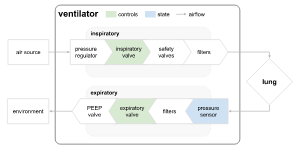

# Table of Contents:
* [Let's Know our Data](#Let's-know-our-data)
* [Basic Trainset Info](#Basic-Trainset-info)
* [Basic Testset Info](#Basic-Testset-info)
* [Basic EDA](#EDA)
* [Feature Engineering](#Feature-Engineering)
* [Modeling](#Modeling)

# Let's know our data

The ventilator data used in this competition was produced using a modified open-source ventilator connected to an artificial bellows test lung via a respiratory circuit. 
The first control input is a continuous variable from 0 to 100 representing the percentage the inspiratory solenoid valve is open to let air into the lung (i.e., 0 is completely closed and no air is let in and 100 is completely open). The second control input is a binary variable representing whether the exploratory valve is open (1) or closed (0) to let air out.

In this competition, we are given numerous time series of breaths and need to learn to predict the **airway pressure** in the respiratory circuit during the breath, given the time series of control inputs.

**Evalution:**
The competition will be scored as the mean absolute error between the predicted and actual pressures during the inspiratory phase of each breath. 

### Data Description:
* **id** - globally-unique time step identifier across an entire file
* **breath_id** - globally-unique time step for breaths
* **R** - lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow.
* **C** - lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.
* **time_step** - the actual time stamp.
* **u_in** - the control input for the inspiratory solenoid valve. Ranges from 0 to 100.
* **u_out** - the control input for the exploratory solenoid valve. Either 0 or 1.
* **pressure** - the airway pressure measured in the respiratory circuit, measured in cmH2O.

In [1]:
# import basic libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# datasets
train = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
test = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')

# Basic Trainset info

In [3]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [4]:
train.tail()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
6035995,6035996,125749,50,10,2.504603,1.489714,1,3.869032
6035996,6035997,125749,50,10,2.537961,1.488497,1,3.869032
6035997,6035998,125749,50,10,2.571408,1.558978,1,3.798729
6035998,6035999,125749,50,10,2.604744,1.272663,1,4.079938
6035999,6036000,125749,50,10,2.638017,1.482739,1,3.869032


In [5]:
train.shape

(6036000, 8)

In [6]:
# a concise summary of a DataFrame.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
 7   pressure   float64
dtypes: float64(3), int64(5)
memory usage: 368.4 MB


In [7]:
# Generate descriptive statistics of the dataset
train.describe()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,3.018000e+06,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,1.742443e+06,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,1.509001e+06,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,3.018000e+06,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,4.527000e+06,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,6.036000e+06,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


In [8]:
# checking null values
train.isna().sum()

id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
pressure     0
dtype: int64

In [9]:
train.nunique().to_frame()

,0
id,6036000
breath_id,75450
R,3
C,3
time_step,3767571
u_in,4020300
u_out,2
pressure,950


# Basic Testset info

In [10]:
test.head()

,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


In [11]:
test.tail()

,id,breath_id,R,C,time_step,u_in,u_out
4023995,4023996,125748,20,10,2.530117,4.971245,1
4023996,4023997,125748,20,10,2.563853,4.975709,1
4023997,4023998,125748,20,10,2.597475,4.979468,1
4023998,4023999,125748,20,10,2.631134,4.982648,1
4023999,4024000,125748,20,10,2.665301,4.985373,1


In [12]:
test.shape

(4024000, 7)

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024000 entries, 0 to 4023999
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
dtypes: float64(2), int64(5)
memory usage: 214.9 MB


In [14]:
test.describe()

,id,breath_id,R,C,time_step,u_in,u_out
count,4.024000e+06,4.024000e+06,4.024000e+06,4.024000e+06,4.024000e+06,4.024000e+06,4.024000e+06
mean,2.012000e+06,6.292796e+04,2.710785e+01,2.607038e+01,1.307083e+00,7.338098e+00,6.203864e-01
std,1.161629e+06,3.624924e+04,1.954281e+01,1.717103e+01,7.658902e-01,1.350955e+01,4.852908e-01
min,1.000000e+00,0.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.006001e+06,3.153050e+04,5.000000e+00,1.000000e+01,6.428454e-01,4.096735e-01,0.000000e+00
50%,2.012000e+06,6.305750e+04,2.000000e+01,2.000000e+01,1.308083e+00,4.377512e+00,1.000000e+00
75%,3.018000e+06,9.433325e+04,5.000000e+01,5.000000e+01,1.965240e+00,4.983472e+00,1.000000e+00
max,4.024000e+06,1.257480e+05,5.000000e+01,5.000000e+01,2.935203e+00,1.000000e+02,1.000000e+00


In [15]:
test.isna().sum()

id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
dtype: int64

In [16]:
test.nunique().to_frame()

,0
id,4024000
breath_id,50300
R,3
C,3
time_step,2855528
u_in,2787822
u_out,2


# EDA

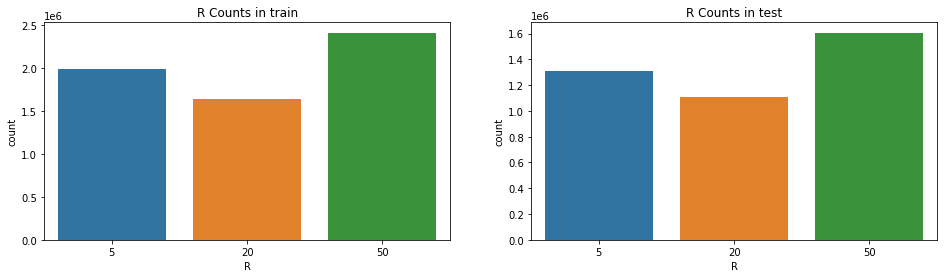

In [17]:
# R(indicating how restricted the airway is) counts
fig, ax = plt.subplots(figsize = (16, 4))
plt.subplot(1, 2, 1)
sns.countplot(x='R', data = train)
plt.title('R Counts in train');
plt.subplot(1, 2, 2)
sns.countplot(x='R', data = test)
plt.title('R Counts in test');

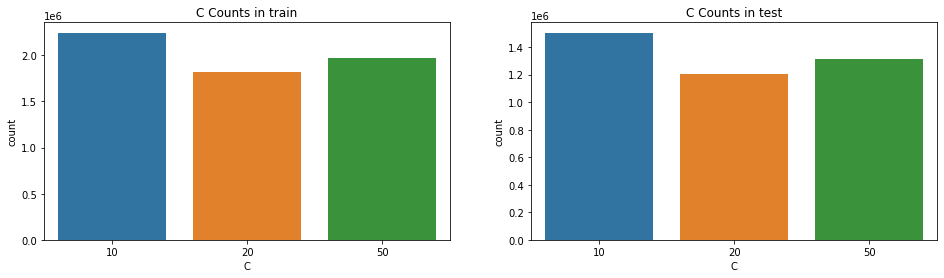

In [18]:
# C(indicating how compliant the lung is) counts
fig, ax = plt.subplots(figsize = (16, 4))
plt.subplot(1, 2, 1)
sns.countplot(x='C', data = train)
plt.title('C Counts in train');
plt.subplot(1, 2, 2)
sns.countplot(x='C', data = test)
plt.title('C Counts in test');

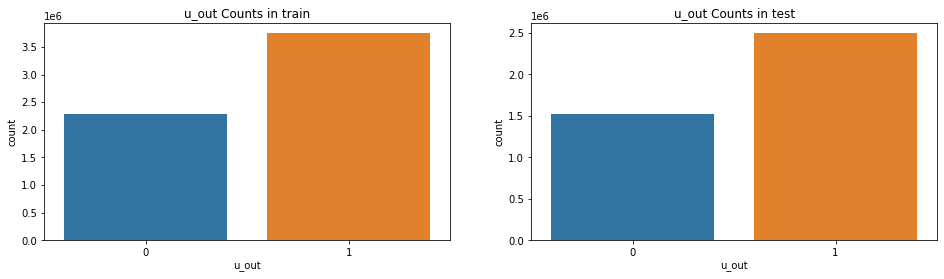

In [19]:
# u_out represent the control input for the exploratory solenoid valve.
fig, ax = plt.subplots(figsize = (16, 4))
plt.subplot(1, 2, 1)
sns.countplot(x='u_out', data = train)
plt.title('u_out Counts in train');
plt.subplot(1, 2, 2)
sns.countplot(x='u_out', data = test)
plt.title('u_out Counts in test');

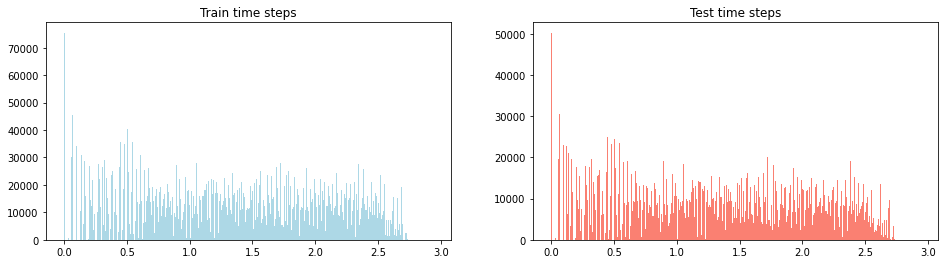

In [20]:
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plt.hist(train['time_step'], bins=500, color = 'lightblue') 
plt.title('Train time steps')

plt.subplot(1,2,2)
plt.hist(test['time_step'], bins=500, color = 'salmon');
plt.title('Test time steps');

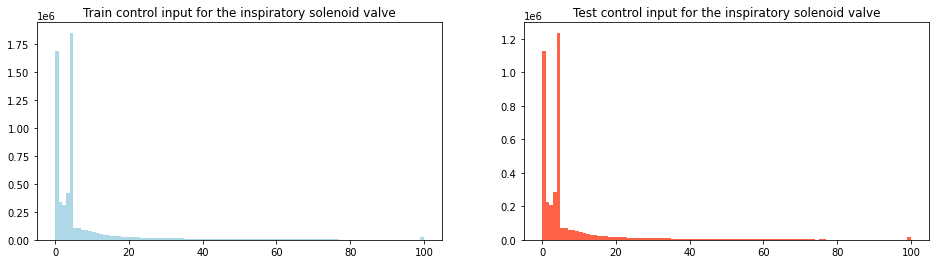

In [21]:
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plt.hist(train['u_in'], bins=100, color = 'lightblue') 
plt.title('Train control input for the inspiratory solenoid valve')

plt.subplot(1,2,2)
plt.hist(test['u_in'], bins=100, color = 'tomato');
plt.title('Test control input for the inspiratory solenoid valve');

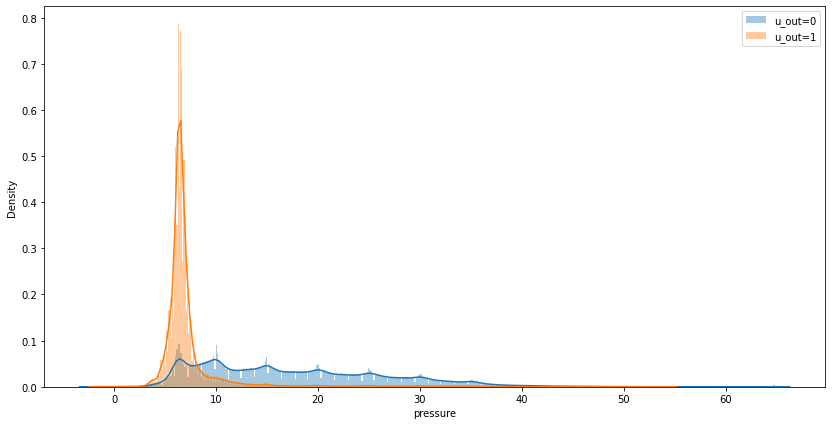

In [22]:
# pressure distribution w.r.t u out
fig, ax = plt.subplots(figsize=(14, 7))
ax = sns.distplot(train.loc[train["u_out"] == 0, "pressure"], ax=ax, label="u_out=0", bins=500)
ax = sns.distplot(train.loc[train["u_out"] == 1, "pressure"], ax=ax, label="u_out=1", bins=500)
ax.legend(loc='upper right');

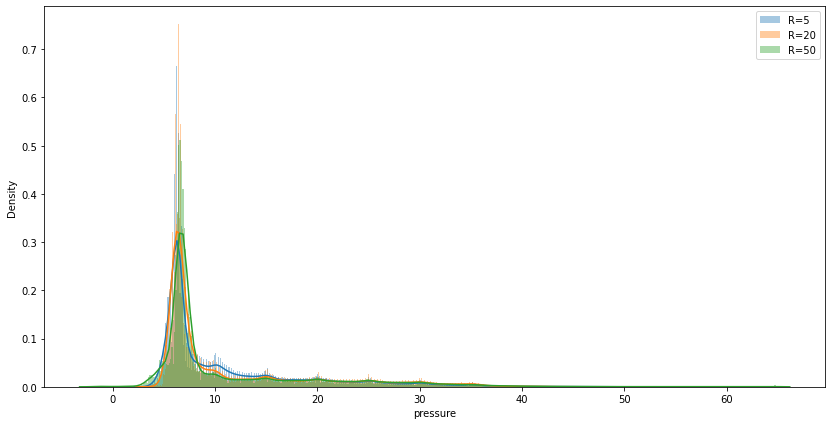

In [23]:
# pressur distribution w.r.t R
fig, ax = plt.subplots(figsize=(14, 7))
ax = sns.distplot(train.loc[train["R"] == 5, "pressure"], ax=ax, label="R=5", bins=500)
ax = sns.distplot(train.loc[train["R"] == 20, "pressure"], ax=ax, label="R=20", bins=500)
ax = sns.distplot(train.loc[train["R"] == 50, "pressure"], ax=ax, label="R=50", bins=500)
ax.legend(loc='upper right');

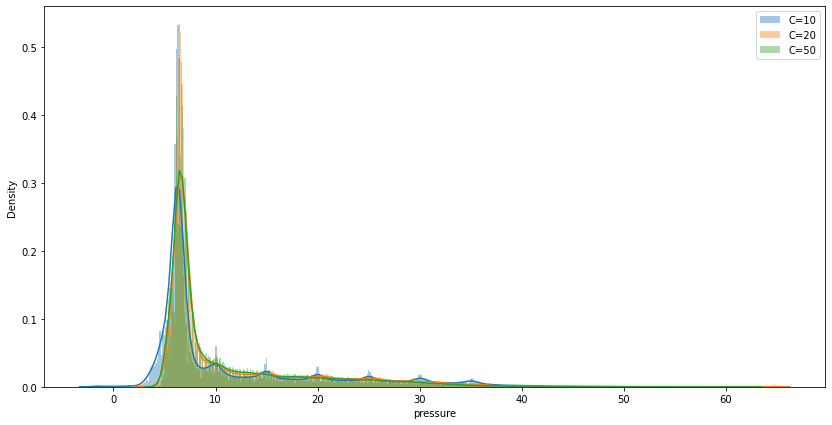

In [24]:
# pressure distribution w.r.t C
fig, ax = plt.subplots(figsize=(14, 7))
ax = sns.distplot(train.loc[train["C"] == 10, "pressure"], ax=ax, label="C=10", bins=500)
ax = sns.distplot(train.loc[train["C"] == 20, "pressure"], ax=ax, label="C=20", bins=500)
ax = sns.distplot(train.loc[train["C"] == 50, "pressure"], ax=ax, label="C=50", bins=500)
ax.legend(loc='upper right');

# Feature Engineering

In [25]:
# credit: https://www.kaggle.com/artgor/ventilator-pressure-prediction-eda-fe-and-models

train['last_value_u_in'] = train.groupby('breath_id')['u_in'].transform('last')
train['u_in_lag'] = train['u_in'].shift(1)
train['u_out_lag'] = train['u_out'].shift(1)
train['u_in_lag_back'] = train['u_in'].shift(-1)
train['u_out_lag_back'] = train['u_out'].shift(-1)
train = train.fillna(0)

# max value of u_in and u_out for each breath
train['breath_id__u_in__max'] = train.groupby(['breath_id'])['u_in'].transform('max')
train['breath_id__u_out__max'] = train.groupby(['breath_id'])['u_out'].transform('max')

# difference between consequitive values
# IMPORTANT: need to rewrite it so that it is calculated only within separate breaths
train['u_in_diff'] = train['u_in'] - train['u_in_lag']
train['u_out_diff'] = train['u_out'] - train['u_out_lag']

# difference between the current value of u_in and the max value within the breath
train['breath_id__u_in__diffmax'] = train.groupby(['breath_id'])['u_in'].transform('max') - train['u_in']
train['breath_id__u_in__diffmean'] = train.groupby(['breath_id'])['u_in'].transform('mean') - train['u_in']

# OHE
train = train.merge(pd.get_dummies(train['R'], prefix='R'), left_index=True, right_index=True).drop(['R'], axis=1)
train = train.merge(pd.get_dummies(train['C'], prefix='C'), left_index=True, right_index=True).drop(['C'], axis=1)

# https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/273974
train['u_in_cumsum'] = train.groupby(['breath_id'])['u_in'].cumsum()

In [26]:
# all the same for the test data
test['last_value_u_in'] = test.groupby('breath_id')['u_in'].transform('last')
test['u_in_lag'] = test['u_in'].shift(1)
test['u_out_lag'] = test['u_out'].shift(1)
test['u_in_lag_back'] = test['u_in'].shift(-1)
test['u_out_lag_back'] = test['u_out'].shift(-1)
test = test.fillna(0)

test['breath_id__u_in__max'] = test.groupby(['breath_id'])['u_in'].transform('max')
test['breath_id__u_out__max'] = test.groupby(['breath_id'])['u_out'].transform('max')

test['u_in_diff'] = test['u_in'] - test['u_in_lag']
test['u_out_diff'] = test['u_out'] - test['u_out_lag']

test['breath_id__u_in__diffmax'] = test.groupby(['breath_id'])['u_in'].transform('max') - test['u_in']
test['breath_id__u_in__diffmean'] = test.groupby(['breath_id'])['u_in'].transform('mean') - test['u_in']

test = test.merge(pd.get_dummies(test['R'], prefix='R'), left_index=True, right_index=True).drop(['R'], axis=1)
test = test.merge(pd.get_dummies(test['C'], prefix='C'), left_index=True, right_index=True).drop(['C'], axis=1)

test['u_in_cumsum'] = test.groupby(['breath_id'])['u_in'].cumsum()

In [27]:
train.shape, test.shape

((6036000, 24), (4024000, 23))

# Modeling

In [28]:
train.drop(['id', 'breath_id'], axis = 1, inplace = True)

In [29]:
# dependent and independent features
x = train.drop(['pressure'], axis = 1)
y = train['pressure']

In [30]:
#splitting the dataset into train and test set.
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state = 31)

In [31]:
len(x_train), len(x_test), len(y_train), len(y_test)

(4527000, 1509000, 4527000, 1509000)

In [32]:
#model evaluation function
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score

def model_evaluate(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return r2, mae
    

In [33]:
%%time
import lightgbm as lgbm
lgbm = lgbm.LGBMRegressor(objective="mae",
                        n_estimators=5000,
                        num_leaves=31,
                        random_state=2021,
                        importance_type="gain",
                        colsample_bytree=0.3,
                        learning_rate=0.5).fit(x_train, y_train)
cv_r2 = cross_val_score(lgbm, x_train, y_train, cv = 3)
print(cv_r2)
y_preds = lgbm.predict(x_test)
cv_r2 = np.mean(cv_r2)
print("Cross val score: " + str(cv_r2))
r2, mae = model_evaluate(y_test, y_preds)
print("R^2 score: " + str(r2))
print("Mean Absolute Erro: " + str(mae))

[0.98507909 0.98533809 0.9849585 ]
Cross val score: 0.9851252251385767
R^2 score: 0.9865335655720536
Mean Absolute Erro: 0.5062823881263516
CPU times: user 3h 2min 32s, sys: 49.4 s, total: 3h 3min 21s
Wall time: 1h 1min 31s


# Preparing to predict

In [34]:
test_df = test.drop(['id', 'breath_id'], axis = 1)

In [35]:
test_df.head()

,time_step,u_in,u_out,last_value_u_in,u_in_lag,u_out_lag,u_in_lag_back,u_out_lag_back,breath_id__u_in__max,breath_id__u_out__max,...,u_out_diff,breath_id__u_in__diffmax,breath_id__u_in__diffmean,R_5,R_20,R_50,C_10,C_20,C_50,u_in_cumsum
0,0.000000,0.000000,0,4.973375,0.000000,0.0,7.515046,0.0,37.542219,1,...,0.0,37.542219,9.327338,1,0,0,0,1,0,0.000000
1,0.031904,7.515046,0,4.973375,0.000000,0.0,14.651675,0.0,37.542219,1,...,0.0,30.027173,1.812292,1,0,0,0,1,0,7.515046
2,0.063827,14.651675,0,4.973375,7.515046,0.0,21.230610,0.0,37.542219,1,...,0.0,22.890543,-5.324338,1,0,0,0,1,0,22.166721
3,0.095751,21.230610,0,4.973375,14.651675,0.0,26.320956,0.0,37.542219,1,...,0.0,16.311609,-11.903272,1,0,0,0,1,0,43.397331
4,0.127644,26.320956,0,4.973375,21.230610,0.0,30.486938,0.0,37.542219,1,...,0.0,11.221263,-16.993619,1,0,0,0,1,0,69.718287


In [36]:
preds = lgbm.predict(test_df)

In [37]:
preds[:10]

array([ 6.64179864,  5.97440109,  6.97114964,  8.16981104,  9.33321566,
       11.40494855, 11.25089425, 12.96520412, 14.18883758, 14.99863702])

In [38]:
sub = pd.DataFrame()
sub['id'] = test.id
sub['pressure'] = preds
sub.head()

,id,pressure
0,1,6.641799
1,2,5.974401
2,3,6.971150
3,4,8.169811
4,5,9.333216


In [39]:
sub.to_csv('submission.csv', index=False)